# Test linearizer

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [22]:
import pandas as pd

from linearization.analyzer import SAELinearizer

## GELU-1L

## Basic setting methods work:

In [23]:
lin = SAELinearizer()

Loaded pretrained model gelu-1l into HookedTransformer
Moving model to device:  cuda
Changing model dtype to torch.float16
Model device: cuda:0
Tokens shape: torch.Size([215402, 128]), dtype: torch.int64, device: cuda:0
Loading run1 from HuggingFace at 25
{'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'd_mlp': 2048,
 'dict_mult': 8,
 'enc_dtype': 'fp32',
 'l1_coeff': 0.0003,
 'lr': 0.0001,
 'model_batch_size': 512,
 'num_tokens': 2000000000,
 'seed': 52,
 'seq_len': 128}
Encoder device: cuda:0


100%|██████████| 25/25 [00:01<00:00, 24.85it/s]


Num dead 0.000244140625


100%|██████████| 25/25 [01:00<00:00,  2.43s/it]


In [24]:
lin.set_feature(10996, "run1")

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 34.04it/s]


In [77]:
lin.set_example("The quick brown fox jumps over the lazy dog", 7)

torch.Size([9])
Token:  the


In [84]:
lin.set_path([("attention", 0, 3)])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2048 and 512x2048)

In [64]:
lin.act_name

'post'

In [81]:
mydf = direct_path_deembed_df = pd.DataFrame(
    zip(lin.model.tokenizer.vocab.keys(), (lin.model.W_E @ lin.range_normal).detach().cpu().numpy())
)
mydf.sort_values(by=1, ascending=False).head(10)

,0,1
8416,Ġeditions,1.202148
13327,"[,",1.005859
24753,rectomy,1.003906
41692,rapeut,0.985352
7830,opathology,0.957520
9613,capt,0.933594
26389,Ġproperties,0.931641
33886,remia,0.886230
29596,Ġcontacted,0.881836
48081,ikes,0.880371


## Match the old notebooks:
Link: [SAE Feature tracing 2](https://colab.research.google.com/drive/1FFq5OAHIrK1i5BovJ3oMFQH8gUMm89Wo?usp=drive_link#scrollTo=RTZud0Rk7qg9)

In [106]:
lin.set_feature(4958, "run1", num_batches=50)  # Due to memory constraints, we only use 50 batches
lin.set_example(7030, 98)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 25.89it/s]


Token:  is


In [61]:
# Confirm examples match - should be "<|BOS|> when Holland and Britain respectively sought..."
print(lin.model.tokenizer.decode(lin.example)[:100])

<|BOS|> when Holland and Britain respectively sought to reconfigure South Africa in strategies that 


In [33]:
# Top examples don't exactly match, due to shuffling of batches, but they show the same interpretation:

for example, col in zip(lin.top_examples["examples"], lin.top_examples["cols"]):
    print(lin.model.tokenizer.decode(example[col - 10 : col + 10]))

, which is sometimes seen as a modern phenomenon, is nothing new. In 1858,
 its scenic vistas, Colorado’s spiritual landscape is largely barren. We have found many people
 because they know their time is short. The earth is not becoming less spiritual. We are headed towards
 to express their masculinity through bodily perfection, which is sometimes seen as a modern phenomenon, is nothing
s deployment of border troops as “political theater” is borne out by news accounts from final April.
 of nature. It is in its recognition that India is trying its best to include the paradigm
 from this slavery and His eternal judgment. Christians have been sent into the entire world to set people free
ility. More importantly, the emotional demeanour is similar to the first song, we lack a
 correct. And just because the true nature of animals is something we don't want to think about,
 feel to Star Trek III. This hateful tone is a direct contrast with the rest of the Trek


In [39]:
# Feature scores for prompt 1
prompt = "When we think about God, we must understand that His love is"
lin.set_example(prompt, token_idx=13)
print(lin.example_scores)
print()

# And for prompt 2
prompt = "What I don't understand is"
lin.set_example(prompt, token_idx=5)
print(lin.example_scores)
print()

# Set example back
lin.set_example(7030, 98)

torch.Size([13])
Token:  is
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.6621, 0.0000]], device='cuda:0',
       dtype=torch.float16, grad_fn=<SelectBackward0>)

torch.Size([6])
Token:  understand
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1541, 0.0000]],
       device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>)

Token:  is


In [108]:
# Check "feature_mid"

# lin.set_path([])
direct_path_deembed_df = pd.DataFrame(
    zip(
        lin.model.tokenizer.batch_decode(list(range(lin.model.tokenizer.vocab_size))),
        (lin.model.W_E @ lin.feature_mid).detach().cpu().numpy(),
    )
)
direct_path_deembed_df.sort_values(1)

,0,1
39089,.'',-0.261719
11214,scheduled,-0.256836
24420,)!,-0.231567
6607,calling,-0.231323
13663,authorized,-0.230957
...,...,...
16531,ARE,0.312988
1441,'re,0.349854
369,was,0.357910
403,are,0.418213


## GELU-2L

In [19]:
lin = SAELinearizer(model_name="gelu-2l", sae_names=["l0", "l1"], layers=[0, 1], act_name="mlp_out")

Loaded pretrained model gelu-2l into HookedTransformer
Moving model to device:  cuda
Changing model dtype to torch.float16
Model device: cuda:0
Tokens shape: torch.Size([215402, 128]), dtype: torch.int64, device: cuda:0
Loading l0 from HuggingFace at gelu-2l_L0_16384_mlp_out_51
{'act_name': 'blocks.0.hook_mlp_out',
 'act_size': 512,
 'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'd_mlp': 512,
 'device': 'cuda:1',
 'dict_mult': 32,
 'dict_size': 16384,
 'enc_dtype': 'fp32',
 'l1_coeff': 0.0003,
 'layer': 0,
 'lr': 0.0001,
 'model_batch_size': 512,
 'model_name': 'gelu-2l',
 'num_tokens': 2000000000,
 'remove_rare_dir': False,
 'seed': 51,
 'seq_len': 128,
 'site': 'mlp_out'}
Encoder device: cuda:0
Loading l1 from HuggingFace at gelu-2l_L1_16384_mlp_out_50
{'act_name': 'blocks.1.hook_mlp_out',
 'act_size': 512,
 'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 '

100%|██████████| 25/25 [00:00<00:00, 31.09it/s]


Num dead 0.1156005859375


100%|██████████| 25/25 [00:00<00:00, 30.49it/s]


Num dead 0.0


 84%|████████▍ | 21/25 [00:49<00:09,  2.36s/it]


KeyboardInterrupt: 

In [ ]:
lin.set_feature(8, "l1")

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 27.07it/s]


In [ ]:
lin.set_example("The quick brown fox jumps over the lazy dog", 7)

torch.Size([9])
Token:  the


In [ ]:
lin.attributions["attn"].shape

torch.Size([2, 8, 11, 11])

## GPT2-small

In [231]:
# This takes like 30 minutes btw, but it's cool...

lin = SAELinearizer(model_name="gpt2-small", sae_names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], layers=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], num_batches=5)

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda
Changing model dtype to torch.float16
Model device: cuda:0
Tokens shape: torch.Size([325017, 128]), dtype: torch.int64, device: cuda:0
Loading Pythia-70M layer 0 from HF
Encoder device: cuda:0
Loading Pythia-70M layer 1 from HF
Encoder device: cuda:0
Loading Pythia-70M layer 2 from HF
Encoder device: cuda:0
Loading Pythia-70M layer 3 from HF
Encoder device: cuda:0
Loading Pythia-70M layer 4 from HF
Encoder device: cuda:0
Loading Pythia-70M layer 5 from HF
Encoder device: cuda:0
Loading Pythia-70M layer 6 from HF


EntryNotFoundError: 404 Client Error. (Request ID: Root=1-65b5730d-4549bb9264cc8abd327f0055;7d151f88-7a1d-4a78-9332-6ddffcdb313e)

Entry Not Found for url: https://huggingface.co/Elriggs/pythia-70M-deduped-sae/resolve/main/pythia-70m-deduped_r4_gpt_neox.layers.6.pt.

In [ ]:
lin.set_feature(8, 0, num_batches=5)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 11.12it/s]


In [ ]:
lin.set_example("The quick brown fox jumps over the lazy dog. The quick brown fox jumps over the lazy dog!!!", 7)

torch.Size([20])
Token:  the


In [ ]:
lin.attributions["ov"].shape

torch.Size([12, 22])

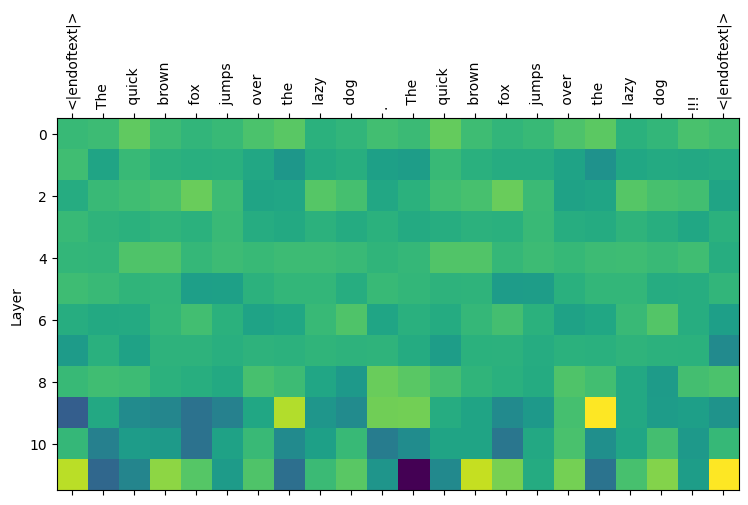

In [ ]:
import matplotlib.pyplot as plt

plt.matshow(lin.attributions["ov"].detach().cpu().numpy().squeeze())
plt.xticks(range(len(lin.example)), [lin.model.tokenizer.decode(x) for x in lin.example], rotation=90)
plt.ylabel("Layer")
plt.show()

# Pythia-70M

The Pythia-70M model has:
* 6 layers
* 512 dimensions in its residual stream
* 8 heads

The SAEs have been trained according to this repo:

https://github.com/HoagyC/sparse_coding/

In particular, this code is of interest:
```python
        c = torch.einsum("nd,bd->bn", learned_dict, batch_centered)
        c = c + params["encoder_bias"]
        c = torch.clamp(c, min=0.0)

        x_hat_centered = torch.einsum("nd,bn->bd", learned_dict, c)
        x_hat = FunctionalTiedSAE.uncenter(buffers, x_hat_centered)

        l_reconstruction = (x_hat_centered - batch_centered).pow(2).mean()
        l_l1 = buffers["l1_alpha"] * torch.norm(c, 1, dim=-1).mean()
        l_bias_decay = buffers["bias_decay"] * torch.norm(params["encoder_bias"], 2)
```


BUT, WHAT IS THE L1 COEFFICIENT?

In [1]:
lin = SAELinearizer(
    model_name="pythia-70m",
    sae_names=[0, 1, 2, 3, 4, 5],
    layers=[0, 1, 2, 3, 4, 5],
    dataset_name="NeelNanda/pile-10k",
    act_name="mlp_out",
    num_batches=50,
)

NameError: name 'SAELinearizer' is not defined

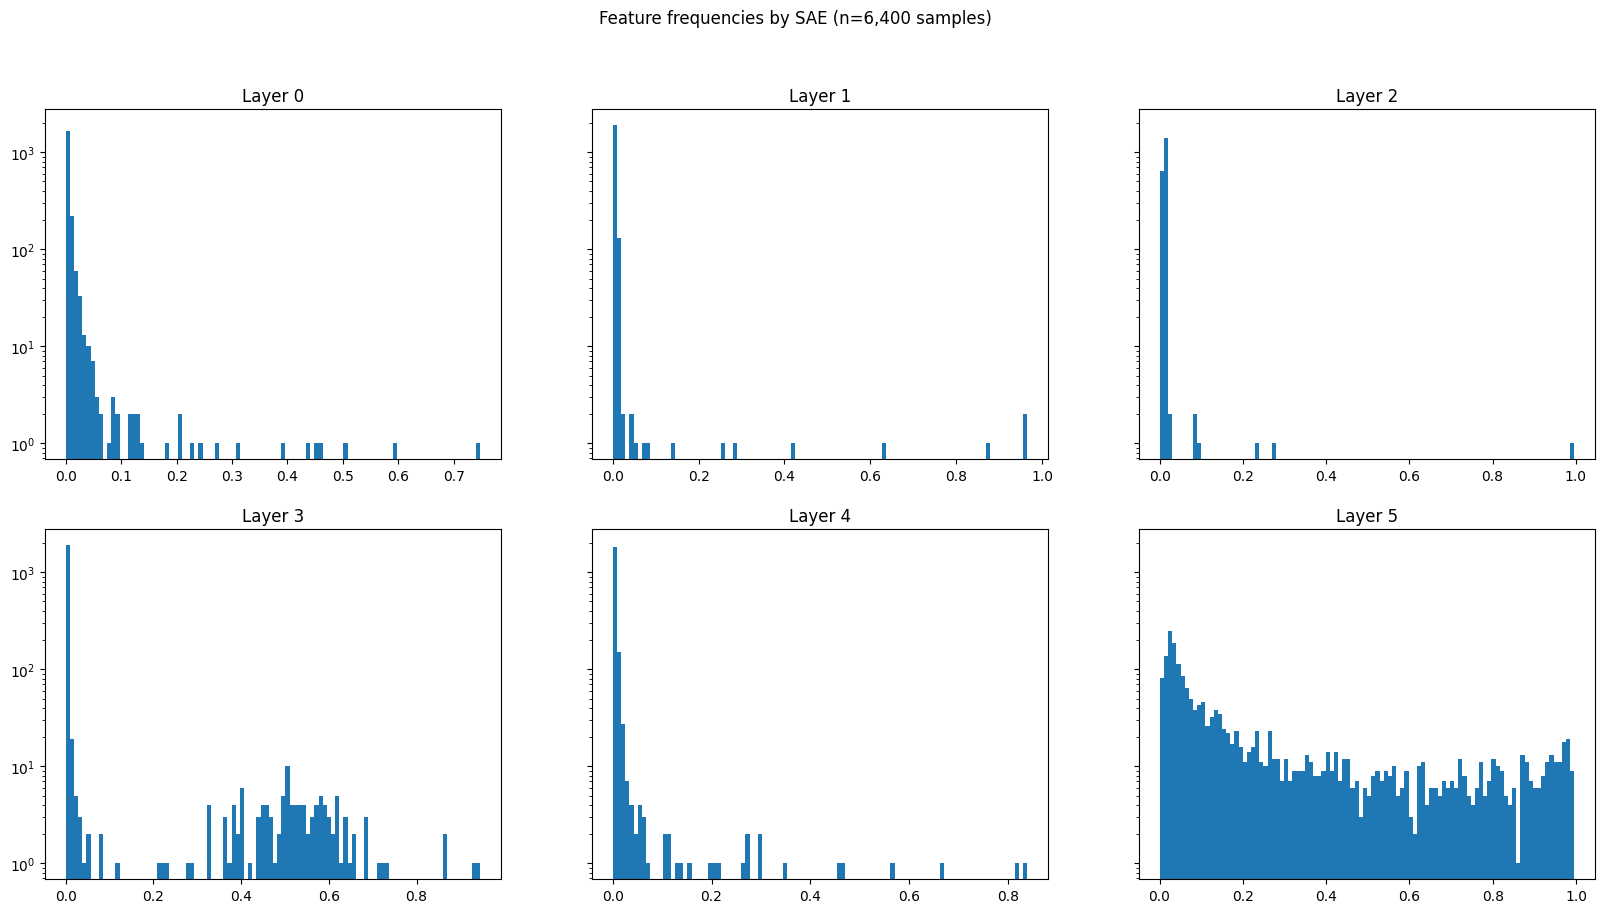

In [226]:
# Plot features
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, sharey=True, figsize=(20, 10))

# lin.frequencies[0].plot(kind="bar", figsize=(20, 10))
for i in range(6):
    freqs = lin.frequencies[i].detach().cpu().numpy()
    axs[i // 3, i % 3].hist(freqs, bins=100)
    axs[i // 3, i % 3].set_title(f"Layer {i}")

plt.yscale("log")
plt.suptitle("Feature frequencies by SAE (n=6,400 samples)")
plt.show()

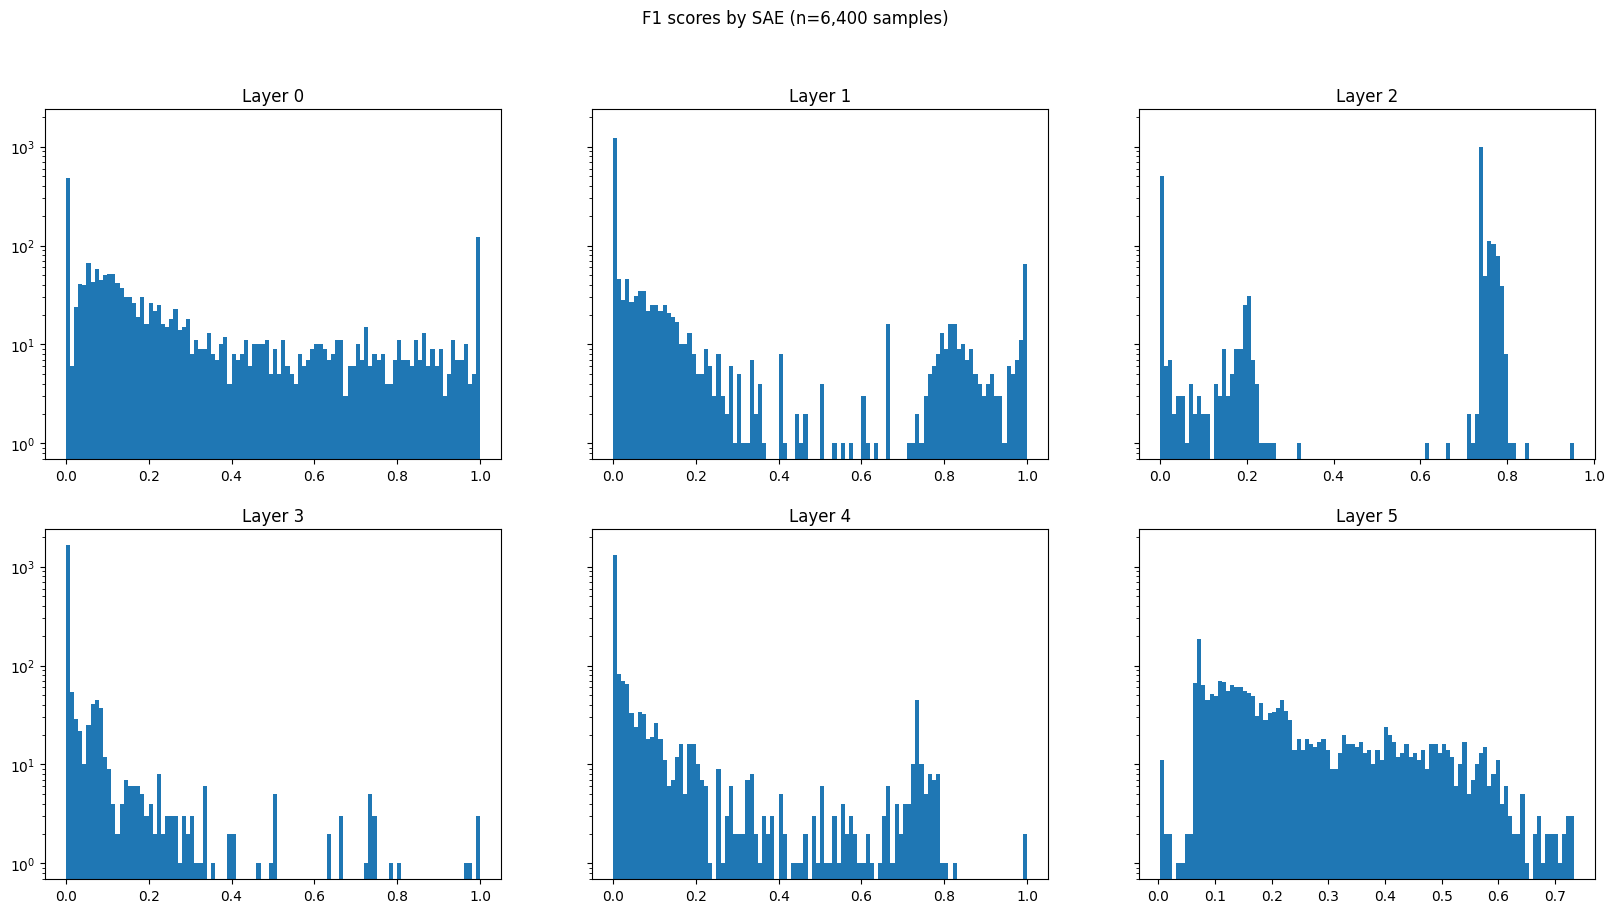

In [227]:
# Same for F1

fig, axs = plt.subplots(2, 3, sharey=True, figsize=(20, 10))

# lin.frequencies[0].plot(kind="bar", figsize=(20, 10))
for i in range(6):
    f1s = lin.f1_scores[i]["f1_scores"]
    axs[i // 3, i % 3].hist(f1s, bins=100)
    axs[i // 3, i % 3].set_title(f"Layer {i}")

plt.yscale("log")
plt.suptitle("F1 scores by SAE (n=6,400 samples)")
plt.show()

In [228]:
lin.set_feature(8, 3)

100%|██████████| 25/25 [00:01<00:00, 20.06it/s]


In [232]:
for example, col in zip(lin.top_examples["examples"], lin.top_examples["cols"]):
    print(lin.model.tokenizer.decode(example[col - 1 : col + 1]))

] and
6992
3 and
,999
 diner
 perhaps even
, and
, and
, Inc
) or


IndexError: index 128 is out of bounds for axis 1 with size 128

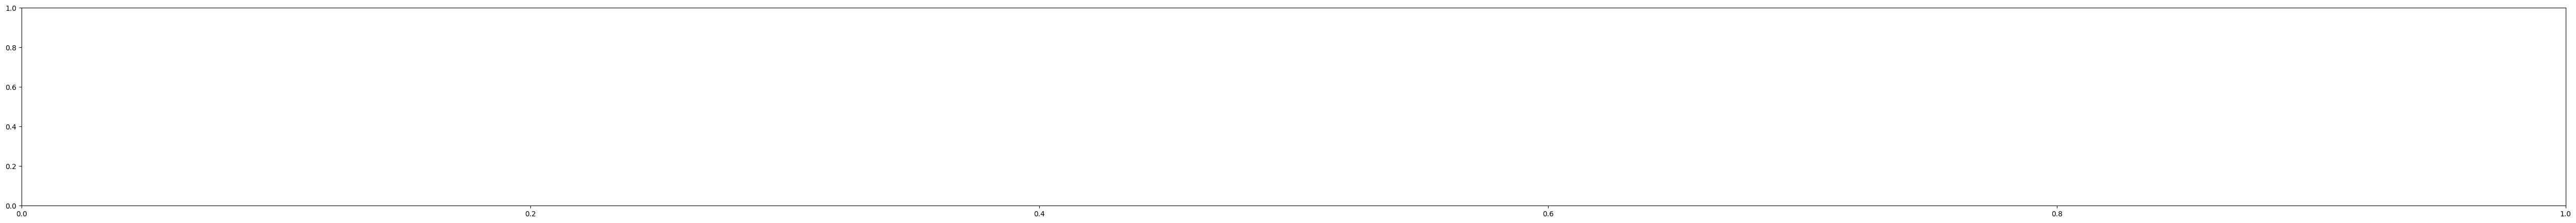

In [247]:
from linearization.visualization import visualize_topk

visualize_topk(
    examples=lin.top_examples["examples"].detach().cpu().numpy(),
    activations=lin.top_examples["activations"].detach().cpu().numpy(),
    columns=lin.top_examples["cols"].detach().cpu().numpy(),
    
)
plt.show()

In [240]:
lin.top_examples["examples"].shape

torch.Size([10, 128])

In [242]:
lin.top_examples["activations"]

tensor([[-3.3555, -3.6973, -4.1523,  ..., -4.6797, -4.1055, -4.1836],
        [-3.3555, -4.2539, -3.9004,  ..., -3.1172, -3.4668, -3.9336],
        [-3.3555, -3.8516, -4.1094,  ..., -3.1836, -4.0352, -3.7715],
        ...,
        [-3.3555, -3.6562, -4.2695,  ..., -3.7188, -4.1641, -3.9297],
        [-3.3555, -3.5137, -3.7168,  ..., -3.7227, -4.3867, -4.2344],
        [-3.3555, -4.0703, -3.8340,  ..., -4.4688, -4.2188, -3.9863]],
       device='cuda:0', dtype=torch.float16)